Box-Office Revenue Prediction

In [1]:
'''Importing Basic Packages'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
'''Importing Scikit Packages'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [3]:
'''CSV Dataset into Pandas Dataframe'''

data = pd.read_csv('imdbboxoffice.csv')
dataTitle = data.style.set_caption("Box Office Data from IMDB")
data.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,The Avengers,6026491,1274885664,Warner Bros.,163620146,253,174687337,R,Animation,16
1,Titanic,169411543,1132871091,Disney,85549990,122,103948486,G,Action,103
2,Jurassic Park,107836098,583329845,Sony,55681429,3826,122104991,NC-17,Horror,89
3,Avatar,51433697,1225323391,Disney,109775324,3868,46431596,G,Horror,85
4,The Lion King,142791649,604140729,Warner Bros.,59476800,2934,203513696,R,Comedy,158


In [4]:
'''Dataset Exploration'''
data.shape #Rows/Columns of Data
data.info() #Data types of data in dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   int64 
 2   world_revenue     2694 non-null   int64 
 3   distributor       2694 non-null   object
 4   opening_revenue   2694 non-null   int64 
 5   opening_theaters  2694 non-null   int64 
 6   budget            2694 non-null   int64 
 7   MPAA              2694 non-null   object
 8   genres            2694 non-null   object
 9   release_days      2694 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 210.6+ KB


Dataset had "object" types in its data instead of integers. Dataset needs to be cleaned in order for further use.

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
domestic_revenue,2694.0,1.508539e+08,8.579997e+07,827765.0,7.673272e+07,152572473.5,2.247314e+08,2.998107e+08
world_revenue,2694.0,7.719177e+08,4.284414e+08,3261301.0,3.991135e+08,766555142.5,1.143920e+09,1.499310e+09
opening_revenue,2694.0,9.971321e+07,5.721762e+07,138569.0,5.033848e+07,99814175.0,1.489805e+08,1.999336e+08
opening_theaters,2694.0,2.263039e+03,1.298559e+03,10.0,1.161000e+03,2271.5,3.392250e+03,4.499000e+03
budget,2694.0,1.537996e+08,8.557624e+07,5197977.0,7.861876e+07,156256716.0,2.274832e+08,2.998597e+08
release_days,2694.0,9.089755e+01,5.089404e+01,1.0,4.700000e+01,91.0,1.350000e+02,1.790000e+02


Will only be using domestic revenue for this project, so there is no need for world or opening revenue (this values might be taken into account in the future).

In [6]:
'''Removing Unecessary Columns'''
remove = ['world_revenue', 'opening_revenue']
data.drop(remove, axis=1, inplace=True)

In [7]:
'''Cleaned Up Dataset'''
data.describe().T #.T is to transpose dataframe columns for readability purposes

,count,mean,std,min,25%,50%,75%,max
domestic_revenue,2694.0,1.508539e+08,8.579997e+07,827765.0,76732721.25,152572473.5,2.247314e+08,299810741.0
opening_theaters,2694.0,2.263039e+03,1.298559e+03,10.0,1161.00,2271.5,3.392250e+03,4499.0
budget,2694.0,1.537996e+08,8.557624e+07,5197977.0,78618761.50,156256716.0,2.274832e+08,299859703.0
release_days,2694.0,9.089755e+01,5.089404e+01,1.0,47.00,91.0,1.350000e+02,179.0


The "world_revenue" and "opening_revenue" columns are not part of the dataset anymore.

In [8]:
'''Calculate Percentage of Missing Values'''
nul = data.isnull().sum() #identifies number of null columns
(nul / data.shape[0]) * 100

title               0.0
domestic_revenue    0.0
distributor         0.0
opening_theaters    0.0
budget              0.0
MPAA                0.0
genres              0.0
release_days        0.0
dtype: float64

Removing other columns like "budget" with too many missing values

In [9]:
'''Handling More Missing Values'''
data.drop('budget', axis=1, inplace=True) #Removing Budget Column

missVals = ['MPAA', 'genres'] #Columns with missing values

for col in missVals:
    data[col] = data[col].fillna(data[col].mode()[0])

data.dropna(inplace=True)

data.isnull().sum().sum()

np.int64(0)

There are still columns with special characters ($ or ,) that are stored as strings. We only care about the numeric data within these columns. Revenue columns should not have the dollar sign in them and numeric values such as 1,000 should not have the "," in them. All of the columns then need to be converted to float types.

In [10]:
'''Special Characters to Numeric Columns'''

data['domestic_revenue'] = data['domestic_revenue'].astype(str).str[1:] #Collects the numeric values in this string data column and ignores the $ character

specChar_cols = ['domestic_revenue', 'opening_theaters', 'release_days']

for col in specChar_cols:
    data[col] = data[col].astype(str).replace(',', '')

    temp = (~data[col].isnull()) #Collects nul data into a temp variable
    data[temp][col] = data[temp][col].convert_dtypes(float) #Converts all remaining data that is nul or something else into float datatype

    data[col] = pd.to_numeric(data[col], errors='coerce') #Convert data in column to numeric data type and if there is an error parsing, then the invalid parsing will be set as "NaN"

    

Now to see how many movies fall under each MPAA rating category (PG, R, PG-13, etc.). This can be done using a horizontal bar chart and matplotlib.

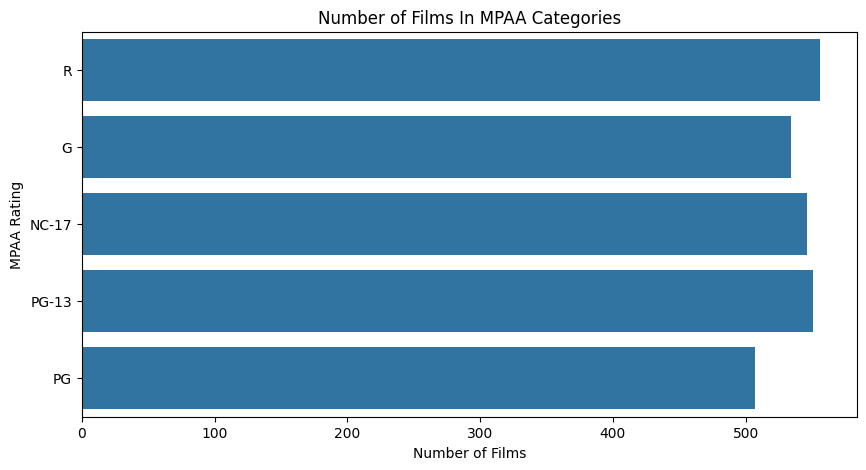

In [11]:
'''Horizontal Bar Chart for MPAA'''
plt.figure(figsize=(10, 5))

bar_colors = ['tab:red', 'tab:green', 'tab:purple', 'tab:blue', 'tab:orange']
plt.title('Number of Films In MPAA Categories')
plt.xlabel("Number of Films")
plt.ylabel('MPAA Rating')

sb.countplot(data['MPAA'])

plt.show()

Calculating the average domestic revenue by MPAA rating is next in order to normalize the data.

In [12]:
'''Average Domestic Revenue by MPAA Rating'''
data.groupby('MPAA')['domestic_revenue'].mean()

MPAA
G        3.426099e+07
NC-17    3.452006e+07
PG       3.697347e+07
PG-13    3.510989e+07
R        3.670206e+07
Name: domestic_revenue, dtype: float64

The movies that are rated R or rated PG have higher revenue than the other rating classes. Now the distribution of the domestic revenue, opening theater revenue, and release day revenue need to be plotted to see if there is any normal distrubition, skewing, outliers, etc.

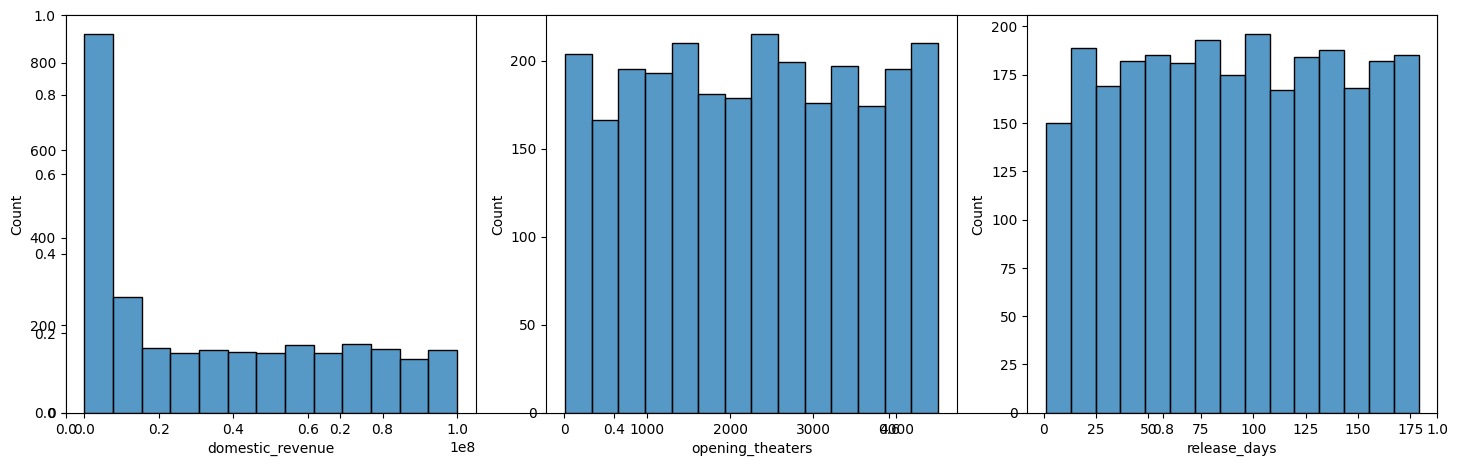

In [18]:
'''Distribution Plots of Columns'''
plt.subplots(figsize=(15, 5))

feats = ['domestic_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(feats, 1):
    plt.subplot(1, 3, i) #3 side-by-side plots in one row
    sb.histplot(data[col])

plt.tight_layout()
plt.show()

Plot 1 is skewed to the left, and plot 2 and 3 resemble normal distributions. Outliers can now be detected via boxplots.

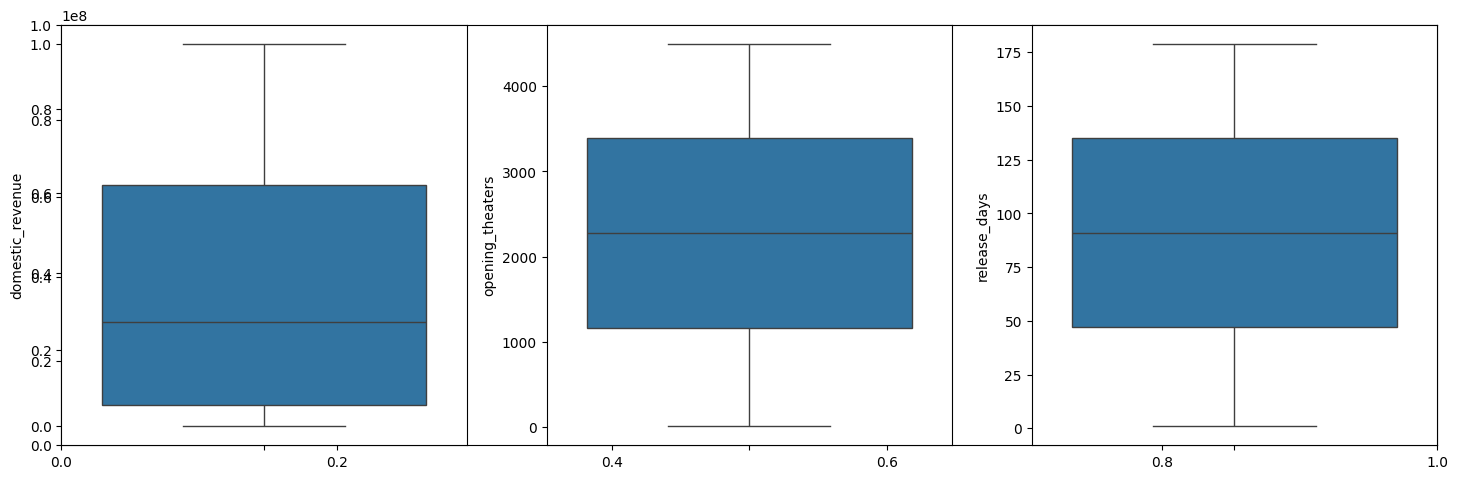

In [21]:
'''Outlier Detection via Boxplots'''
plt.subplots(figsize=(15, 5))

for i, col in enumerate(feats, 1):
    plt.subplot(1, 3, i)
    sb.boxplot(data[col])

plt.tight_layout()
plt.show()

There are no outliers in any of the plots since there are no data points plotted above the maximum or minimum for any of the plots.